### Standard code taken from Tirgul

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import *

In [2]:
def plot_image(image, title=""):
    image = np.clip(image,0,255)
    image = image.astype(np.uint8)
    
    # added conditional for title
    if title:
        plt.title(title)

    plt.imshow(image,cmap='gray')
    plt.show()

def rgb2gray_naive(rgb_image):

    r, g, b = rgb_image[:,:,0], rgb_image[:,:,1], rgb_image[:,:,2]
    gray_image = 0.1 * r + 0.1 * g + 0.8 * b

    return gray_image

In [3]:
# using requests instead because urllib returned an HTTP 403 code 
import requests

image_url = 'https://c1.peakpx.com/wallpaper/19/103/818/golden-retriever-greyscale-photography-wallpaper-preview.jpg'
image_path = 'image.jpg'
with open(image_path, 'wb') as f:
    f.write(requests.get(image_url).content)

In [4]:
# load image and convert to grayscale
image = plt.imread(image_path).astype(float)
gray_image = rgb2gray_naive(image).astype(float)

### Noise functionality

In [5]:
# applies a noise generated by 'noise_f' to each pixel in 'image' using 'operator'
def apply_noise(image, noise_f, operator):
    
    # newImage_i,j = image_i,j (operator) noise_i,j
    new_image = np.vectorize(operator)(image, noise_f(image.shape))
    return np.clip(new_image, 0, 255)

''' noise generators '''
# generate salt and pepper noise in shape 'shape'. -1 for unchanged values
def salt_rand(shape, p1, p2):

    vf = np.vectorize(lambda x: 0 if x < p1 else (255 if x > p2 else -1))
    return vf(np.random.random(shape))

# generate gaussian noise in shape 'shape'
def gaus_rand(shape, sigma, mu):
    return np.random.normal(sigma, mu, shape)

''' operators '''
def add_op(a, b):
    return a + b

# ad-hoc. replace with noise only for valid noise elements
def salt_op(a, b):
    return b if b >= 0 else a

### And convolutions

In [6]:
# calculates a convolution function conv_f with kernel 'kernel' on 'image'
def conv(image, conv_f, kernel):
    
    # kinda disgusting. I tried making it with numpy but getting indices or sub-matrices would not work.
    h,w = image.shape
    k = len(kernel)
    return np.clip([[conv_f(image[i:i+k,j:j+k], kernel) for j in range(w-k)] for i in range(h-k)], 0, 255) 

''' convolution functions '''
# returns the median of the neighbors. ignores the k argument
def median_conv(neighbors, k):
    n = np.sort(neighbors.flatten())
    m = (len(n) - 1) / 2
    return (n[int(np.ceil(m))] + n[int(np.floor(m))]) // 2 # rounded down because pixel

# returns the sum of the element-wise product ('neighbors' x 'kernel')
def sum_conv(neighbors, kernel):
    return np.sum(np.multiply(neighbors.flatten(), kernel.flatten()))

### Applying and filtering Gaussian noise

In [7]:
# gaussian noise parameters
sigma = 0
mu = 30
op_gaus = add_op # we'd like the noise to be additive

p_gaus = partial(gaus_rand, sigma=sigma, mu=mu)

# applying the noise
noisy_gaus = apply_noise(gray_image, p_gaus, op_gaus)

We will use the __average-filter__. It allows us to 'smooth' the neighbors out and reduce the noise's expected value and std.

In [8]:
# create an average-kernel
gaus_k_size = 3
gaus_kernel = np.ones((gaus_k_size, gaus_k_size)) / (gaus_k_size ** 2)

# convolve
filtered_gaus = conv(noisy_gaus, sum_conv, gaus_kernel)

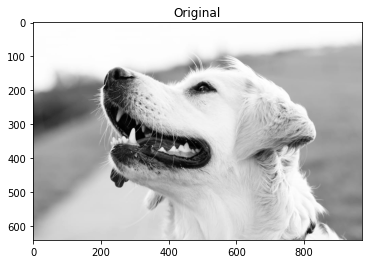

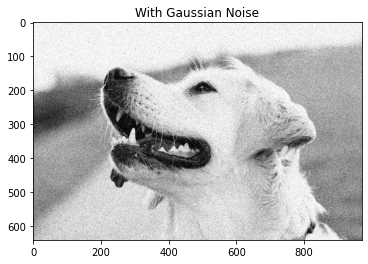

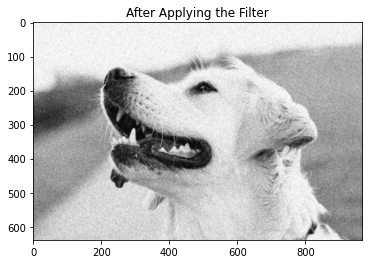

In [9]:
plot_image(gray_image, "Original")
plot_image(noisy_gaus, "With Gaussian Noise")
plot_image(filtered_gaus, "After Applying the Filter")

### Applying and filtering Salt-and-Pepper noise

In [10]:
# salt and pepper noise parameters
p1 = 0.1
p2 = 0.9
op_salt = salt_op # we'd like to apply the noise in a special way

p_salt = partial(salt_rand, p1=p1, p2=p2)

# applying the noise
noisy_salt = apply_noise(gray_image, p_salt, op_salt)

We chose to use the __median-filter__. Taking the median of the neighbors allows us to neutralise extreme outlier noise, such as the salt and pepper, as the median is not sensitive to it. 

In [11]:
# create a median-kernel
salt_k_size = 3
salt_k = np.zeros((salt_k_size, salt_k_size)) # a random kernel of the right size

# convolve
filtered_salt = conv(noisy_salt, median_conv, salt_k)

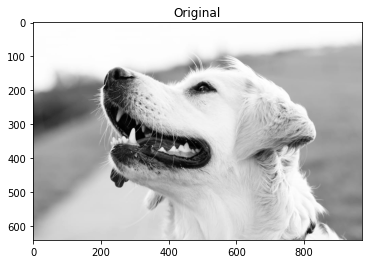

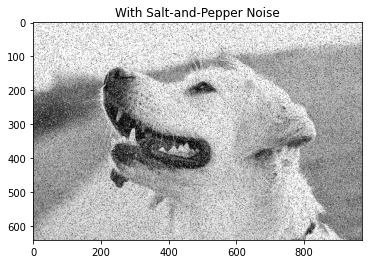

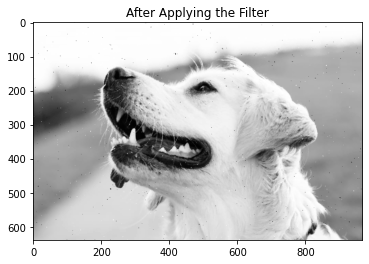

In [12]:
plot_image(gray_image, "Original")
plot_image(noisy_salt, "With Salt-and-Pepper Noise")
plot_image(filtered_salt, "After Applying the Filter")